In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
from cca.data_util import load_neuro_data, get_active_channels, sliding_z_score, load_mocap_data, sum_over_chunks
from cca.kron_pca import toeplitzify, form_lag_matrix, cv_toeplitz

#Neural data params
NEURO_DATA_DIR = "/Users/davidclark/Projects/ComplexityComponentsAnalysis/neuro_data/"
NEURO_DATA_FILENAMES = [] #["example_data_m1.pickle", "example_data_s1.pickle", "example_data_hc.pickle"]
NEURO_DATASET_NAMES = [] #["M1/PMd", "S1", "Hippocampus"]

BIN_WIDTH_S = 0.1
Z_SCORE_WINDOW_S = 120.
MIN_SPIKES_PER_WINDOW = [400, 10, 1]

#MOCAP data params
MOCAP_DATA_DIR = "/Users/davidclark/Projects/ComplexityComponentsAnalysis/neuro_data/"
MOCAP_DATA_FILENAMES = ["08_"+num+".amc" for num in ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]]
MOCAP_DATASET_NAME = "Joint Angles, Walking"

#Shared regularization params
T = 10
R_VALS = np.arange(1, 2*T)
SIGMA_VALS = np.append(np.linspace(1., 4*T, 5), 1e8)
ALPHA_VALS = np.linspace(0, 0.1, 5)
PARAM_NAMES = ["$r$", "$\sigma$", "$\\alpha$"]
NUM_FOLDS = 5
DATASET_NAMES = NEURO_DATASET_NAMES + [MOCAP_DATASET_NAME]

In [228]:
#Form list of all datasets for analysis

datasets = []

In [229]:
#Load neural datasets
neuro_datasets = [load_neuro_data(NEURO_DATA_DIR + filename, bin_width_s=BIN_WIDTH_S)[0] for filename in NEURO_DATA_FILENAMES]

#Z-score neural datasets
z_score_window_bins = int(np.round(Z_SCORE_WINDOW_S / BIN_WIDTH_S))
for dataset_idx in range(len(neuro_datasets)):
    X = neuro_datasets[dataset_idx]
    min_spikes = MIN_SPIKES_PER_WINDOW[dataset_idx]
    active_channels = get_active_channels(X, z_score_window_bins, min_spikes)
    N = np.sum(active_channels)
    print(NEURO_DATASET_NAMES[dataset_idx] + ": ")
    print(str(N) + " active channels (" + str(np.round(100 * N/X.shape[1], 2)) + "%)\n")
    X_active = X[:, active_channels]
    X_sqrt = np.sqrt(X_active)
    X_z_score = sliding_z_score(X_sqrt, z_score_window_bins)
    datasets.append(X_z_score)

(1178, 56)
1.8313631848241355e-14
-0.12644540748245253


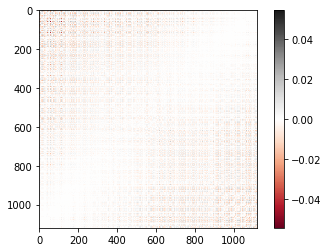

In [48]:
#Load mocap datasets
mocap_datasets = [load_mocap_data(MOCAP_DATA_DIR + filename) for filename in MOCAP_DATA_FILENAMES]

#Z-score and concatenate mocap datasets
good_idx = np.ones(62, dtype=np.bool)
for X in mocap_datasets:
    good_idx *= (X.std(axis=0) > 1e-6)
X = np.concatenate(mocap_datasets, axis=0)[:, good_idx]
#X = sliding_z_score(X, 120) #1 second
X = (X-X.mean(axis=0))/X.std(axis=0)
X = scipy.ndimage.gaussian_filter1d(X, axis=0, sigma=3)
X = X[::3]
print(X.shape)
#X += np.random.normal(0, 0.05, X.shape)
T_pi = 20
X_lags = form_lag_matrix(X, T_pi)
cov = np.dot(X_lags.T, X_lags)/len(X_lags)
cov_toep = toeplitzify(cov, X.shape[1], T_pi)

diff = cov - cov_toep
max_val = np.max(np.abs(diff))
plt.imshow(diff, vmin=-max_val, vmax=max_val, cmap="RdGy")
plt.colorbar()

print(np.min(scipy.linalg.eigvalsh(cov)))
print(np.min(scipy.linalg.eigvalsh(cov_toep)))



In [179]:
#Do hyperparameter scan
#NOTE: skip to next cell if results have already been generated and saved


ll_results = np.zeros((len(datasets), len(R_VALS), len(SIGMA_VALS), len(ALPHA_VALS)))
opt_idx_results = np.zeros((len(datasets), 3), dtype=np.int)
for dataset_idx in range(len(datasets)):
    X = datasets[dataset_idx]
    #X = X + np.random.normal(0, 0.05, X.shape)
    X_lags = form_lag_matrix(X, T)
    cov = np.dot(X_lags.T, X_lags)/len(X_lags)
    cov_toep = toeplitzify(cov, X.shape[1], T)
    w = scipy.linalg.eigvalsh(cov_toep)
    print(DATASET_NAMES[dataset_idx] + ": ")
    print("Minimum Toeplitz covariance eigenvalue = " + str(np.min(w)))
    N = X.shape[1]
    ll_vals, opt_idx = cv_toeplitz(X_lags, N, T, R_VALS, SIGMA_VALS, ALPHA_VALS, num_folds=NUM_FOLDS, verbose=True)
    ll_results[dataset_idx] = ll_vals.mean(axis=0)
    opt_idx_results[dataset_idx] = opt_idx
    
#Save results to file
np.save("ll_results_mocap.npy", ll_results)
np.save("opt_idx_results_mocap.npy", opt_idx_results)

Joint Angles, Walking: 
Minimum Toeplitz covariance eigenvalue = 3.7863172167938346e-05
fold = 1
r = 1
r = 2
r = 3
r = 4
r = 5
r = 6
r = 7
r = 8
r = 9
r = 10
r = 11
r = 12
r = 13
r = 14
r = 15
r = 16
r = 17
r = 18
r = 19
fold = 2
r = 1
r = 2
r = 3
r = 4
r = 5
r = 6
r = 7
r = 8
r = 9
r = 10
r = 11
r = 12
r = 13
r = 14
r = 15
r = 16
r = 17
r = 18
r = 19
fold = 3
r = 1
r = 2
r = 3
r = 4
r = 5
r = 6
r = 7
r = 8
r = 9
r = 10
r = 11
r = 12
r = 13
r = 14
r = 15
r = 16
r = 17
r = 18
r = 19
fold = 4
r = 1
r = 2
r = 3
r = 4
r = 5
r = 6
r = 7
r = 8
r = 9
r = 10
r = 11
r = 12
r = 13
r = 14
r = 15
r = 16
r = 17
r = 18
r = 19
fold = 5
r = 1
r = 2
r = 3
r = 4
r = 5
r = 6
r = 7
r = 8
r = 9
r = 10
r = 11
r = 12
r = 13
r = 14
r = 15
r = 16
r = 17
r = 18
r = 19


In [181]:
#Calculate unregularized log likelihood values

unreg_ll = np.zeros(len(datasets))
for dataset_idx in range(len(datasets)):
    X = datasets[dataset_idx]
    X_lags = form_lag_matrix(X, T)
    N = X.shape[1]
    ll_vals, _ = cv_toeplitz(X_lags, N, T, [2*T-1], [1e8], [0.0], num_folds=NUM_FOLDS)
    ll = ll_vals.mean(axis=0).flatten()[0]
    unreg_ll[dataset_idx] = ll

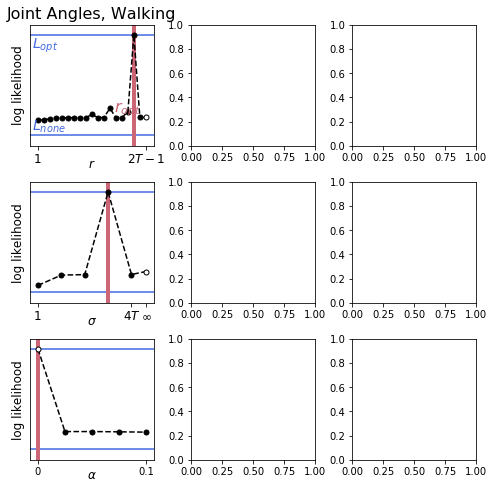

In [182]:
#Plot results for all datasets

ll_results = np.load("ll_results_mocap.npy")
opt_idx_results = np.load("opt_idx_results_mocap.npy")
param_sets = [R_VALS, SIGMA_VALS, ALPHA_VALS]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

colors = ["#332288", "#88CCEE", "#44AA99", "#117733",
          "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
c_hlines = "royalblue"
c_vlines = colors[6]
tick_size = 12
label_size = 12
title_size = 16

for dataset_idx in range(len(datasets)):
    
    ll_vals = ll_results[dataset_idx]
    opt_idx = opt_idx_results[dataset_idx]
    unreg_ll_val = unreg_ll[dataset_idx]
    amt = 1.1*(np.max(ll_vals) - unreg_ll_val)
    
    for param_idx in range(len(param_sets)):
        
        ax = axes[param_idx, dataset_idx]
        
        params = param_sets[param_idx]
        max_ax = list(range(len(param_sets)))
        max_ax.remove(param_idx)
        max_ll_vals = ll_vals.max(axis=tuple(max_ax))
        
        #Plot min and max lines
        ax.axhline(unreg_ll_val, zorder=0, color=c_hlines)
        ax.axhline(np.max(ll_vals), zorder=0, color=c_hlines)
        ax.set_ylim([unreg_ll_val-0.1*amt, unreg_ll_val+amt])
        
        #Make line for the main curve (no markers yet) 
        if param_idx == 1:
            x_vals = np.copy(params)
            x_vals[-1] = 4*T + 6
        else:
            x_vals = params
        ax.axvline(x_vals[opt_idx[param_idx]], c=c_vlines, linewidth=4.0, alpha=1.0, zorder=0)   
        
        #Add tick labels and decide where the special marker should go
        if param_idx == 0:
            ax.set_xticks([1, 2*T-1])
            ax.set_xticklabels(["1", "$2T-1$"], fontsize=tick_size)
            ax.set_title(DATASET_NAMES[dataset_idx], fontsize=title_size)
            star_idx = len(x_vals) - 1
        if param_idx == 1:
            ax.set_xticks([1, 4*T, x_vals[-1]])
            ax.set_xticklabels(["1", "$4T$", "$\infty$"], fontsize=tick_size)
            star_idx = len(x_vals) - 1
        elif param_idx == 2:
            ax.set_xticks([0, np.max(params)])
            ax.set_xticklabels([0, np.round(params[-1], 2)])
            star_idx = 0
        
        #Add markers
        ax.plot(x_vals, max_ll_vals, c="black", linestyle="--", zorder=0)
        for i in range(len(x_vals)):
            if i == star_idx:
                facecolors = "white"
            else:
                facecolors = "black"
            ax.scatter([x_vals[i]], [max_ll_vals[i]],
                       color="black", s=25, facecolors=facecolors) 
        
        #Add y label if necessary
        if dataset_idx == 0:
            ax.set_ylabel("log likelihood", fontsize=label_size, labelpad=5)
        
        #Remove y ticks
        ax.set_yticks([])
        
        #Add x label
        ax.set_xlabel(PARAM_NAMES[param_idx], fontsize=label_size, labelpad=-8)
        

ax = axes[0, 0]
ax.text(0.68, 0.3, "$r_{opt}$", horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, color=c_vlines, fontsize=16)
ax.text(0.02, 0.83, "$L_{opt}$", horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, color=c_hlines, fontsize=14)
ax.text(0.02, 0.16, "$L_{none}$", horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, color=c_hlines, fontsize=14)


#plt.savefig("figs/reg_results.pdf", bbox_inches="tight")
plt.show()



In [164]:
T = 5

mocap_datasets = [load_mocap_data(MOCAP_DATA_DIR + filename) for filename in MOCAP_DATA_FILENAMES]
good_idx = np.ones(62, dtype=np.bool)
for X in mocap_datasets:
    good_idx *= (X.std(axis=0) > 1e-6)
X = np.concatenate(mocap_datasets, axis=0)[:, good_idx]
#X = scipy.ndimage.gaussian_filter1d(X, axis=0, sigma=1)
print(X.shape)

X = sliding_z_score(X, 120)
X = (X-X.mean(axis=0))/X.std(axis=0)

cov = np.dot(X.T, X)/len(X)
w = np.linalg.eigvalsh(cov)[::-1]
pve = np.cumsum(w)/np.sum(w)
pve[30]




(2079, 56)


0.995222826581921

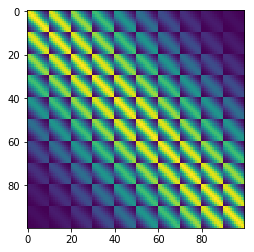

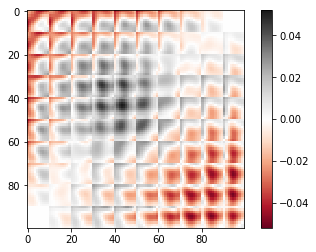

In [70]:
from cca.synth_data import gen_gp_kernel, calc_pi_for_gp, gen_gp_cov

K = gen_gp_kernel("squared_exp", 5, 5)
cov = gen_gp_cov(10, 10, K)
plt.imshow(cov)
plt.show()

X_lags = np.random.multivariate_normal(mean=np.zeros(100), cov=cov, size=1000)
cov = np.dot(X_lags.T, X_lags)/len(X_lags)
cov_toep = toeplitzify(cov, 10, 10)

diff = cov - cov_toep
s = np.max(np.abs(diff))
plt.imshow(diff, vmin=-s, vmax=s, cmap="RdGy")
plt.colorbar()
plt.show()

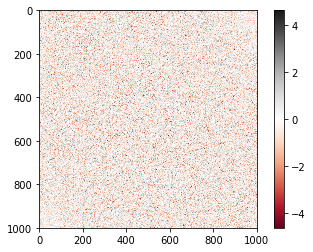

In [52]:
n = 100
t = 10
a = np.random.normal(0, 1, (n*t, n*t))
a_toep = toeplitzify(a, n, t)

mat = a - a_toep
s = np.max(np.abs(mat))
plt.imshow(mat, vmin=-s, vmax=s, cmap="RdGy")
plt.colorbar()